<a href="https://colab.research.google.com/github/janxl/colabs/blob/master/MeshObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
!pip install trimesh
!pip install pyrender

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 624kB 4.6MB/s 
     |████████████████████████████████| 1.2MB 5.2MB/s 
     |████████████████████████████████| 1.2MB 31.1MB/s 
     |████████████████████████████████| 890kB 48.1MB/s 
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-cp36-none-any.whl size=1745212 sha256=7fa399b4ac6b14f5d667e505576751af6aa8e617389ef2ab101ad90301de8f5b
  Stored in directory: /root/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58
Successfully built PyOpenGL
  Found existing installation: PyOpenGL 3.1.5
    Uninstalling PyOpenGL-3.1.5:
      Successfully uninstalled PyOpenGL-3.1.5


In [2]:
import os
import numpy as np
import trimesh
import pyrender
import matplotlib.pyplot as plt
import json
import cv2
import re
import glob
import skimage as ski
from skimage import io
import skimage.draw
from tqdm import tqdm 
from PIL import Image, ImageOps
import shutil 
os.environ["PYOPENGL_PLATFORM"] = "egl"

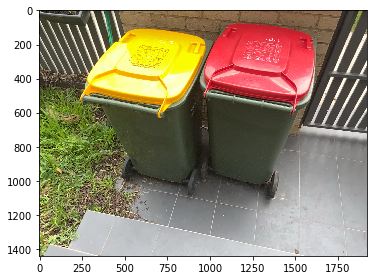

In [4]:
filename = 'frame_00019'
photo = io.imread(filename+'.jpg')
io.imshow(photo)
io.show()

In [5]:

img_h, img_w, nrC = photo.shape
print("w:{} h:{}".format(img_w,img_h))

w:1920 h:1440


In [6]:
with open(filename+'.json') as f:
  data = json.load(f)
camera_pose = data['cameraPoseARFrame']
camera_pose = np.array(camera_pose).reshape([4,4])
print(camera_pose)
proj_m = data['projectionMatrix']
proj_m = np.array(proj_m).reshape([4,4])
yfov_radians = 2*math.atan(1./proj_m[1][1])
print(proj_m)
print("yfov:{}".format(yfov_radians))
view_m = np.linalg.inv(camera_pose)
mvp = np.dot(proj_m, view_m)
print(mvp)


[[-0.9997704  -0.01575893 -0.01451242 -2.08494544]
 [-0.02120131  0.63056266  0.77584863  1.69929254]
 [-0.00307555  0.77597827 -0.63075209 -1.74660969]
 [ 0.          0.          0.          1.        ]]
[[ 1.65928864e+00  0.00000000e+00  1.57160163e-02  0.00000000e+00]
 [ 0.00000000e+00  2.21238494e+00 -1.70893669e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.99999762e-01 -9.99999815e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  0.00000000e+00]]
yfov:0.8490332716808028
[[-1.65913607 -0.02298583 -0.01501615 -3.44637588]
 [-0.03461682  1.38178879  1.72754193  0.59710391]
 [ 0.01451242 -0.77584854  0.63075197  2.44932876]
 [ 0.01451243 -0.77584873  0.63075212  2.45032935]]


In [19]:
def project_point_mvp(p_in, mvp, image_width, image_height):
    p0 = np.append(p_in, [1])
    e0 = np.dot(mvp, p0)
    e0[:3] /= e0[3]
    pos_x = e0[0]
    pos_y = e0[1]
    px = (0.5 + (pos_x) * 0.5) * image_width
    py = (1.0 - (0.5 + (pos_y) * 0.5)) * image_height
    return int(round(px)), int(round(py))

In [ ]:
invp_m = np.linalg.inv(proj_m)
test3d = (-1.8,0.789,-0.822)
print(test3d)
test2d = project_point_mvp(test3d, mvp, img_w, img_h)
print(test2d)
x1 = (test2d[0]/img_w-0.5)*2
y1 = -(test2d[1]/img_h-0.5)*2
print('{} {}'.format(x1,y1))
pvm = np.dot(camera_pose, invp_m)
print(pvm)
#w=1.29358409
#z=0.99922672
w=1
z=0.99922672
try1 = [x1*w, y1*w, z*w, w]
print(try1)
g1=np.dot(pvm, try1)
print(g1)
g1 = g1[:3]/g1[3]
print(g1)

(-1.8, 0.789, -0.822)
[-0.46572351  0.32960607  1.29258378  1.29358409]
[-0.36002569  0.25480065  0.99922672  1.29358409]
(614, 537)
-0.3604166666666667 0.25416666666666665
[[-6.02529527e-01 -7.12305224e-03  2.08494583e+03 -2.08494016e+03]
 [-1.27773460e-02  2.85014896e-01 -1.69929286e+03  1.69851153e+03]
 [-1.85353628e-03  3.50742881e-01  1.74661001e+03 -1.74598487e+03]
 [ 0.00000000e+00  0.00000000e+00 -1.00000019e+03  9.99999947e+02]]
[-0.3604166666666667, 0.25416666666666665, 0.99922672, 1]
[-1.3912338   0.60975033 -0.63565799  0.77304172]
[-1.79968785  0.78876768 -0.8222816 ]


In [8]:
bboxs = []
with open('ai.json') as f:
  aidata = json.load(f)
objects = aidata['localizedObjectAnnotations']
for poly in objects:
  vertices = poly['boundingPoly']['normalizedVertices']
  ul = (int(vertices[0]['x']*img_w),int(vertices[0]['y']*img_h))
  lr = (int(vertices[2]['x']*img_w),int(vertices[2]['y']*img_h))
  bboxs.append([ul,lr])
print(bboxs)
mid1 = (int((bboxs[0][1][0]+bboxs[0][0][0])/2),int((bboxs[0][1][1]+bboxs[0][0][1])/2))
print (mid1)

[[(241, 101), (1002, 1060)], [(935, 74), (1599, 1088)]]
(621, 580)


In [31]:
def is_2dpoint_in_bbox(p2d, bbox):
    if(p2d[0]>bbox[0][0] and p2d[0]<bbox[1][0]):
      if(p2d[1]>bbox[0][1] and p2d[1]<bbox[1][1]):
        return True
    return False

In [49]:
obj_scene = trimesh.load('export.obj')
#obj_scene.visual.vertex_colors = np.random.uniform(size=obj_scene.vertices.shape)
#obj_scene.visual.face_colors = np.random.uniform(size=obj_scene.faces.shape)
#obj_scene.apply_transform(camera_pose)
obj_scene.remove_duplicate_faces()
obj_scene.show()






In [41]:
print(obj_scene.vertices[0])
print(obj_scene.faces[0])
print(obj_scene.edges[0])

[-0.     0.76   0.495]
[ 4828  4829 23661]
[4828 4829]


In [47]:
print(obj_scene.vertices[0])

[-0.     0.76   0.495]


In [51]:
print(bboxs[0])
p3d= (-1.8594618082046508, 0.7895047783851622, -0.8226267814636229)
p2d = project_point_mvp(p3d, mvp, img_w, img_h)
print(p2d)
isIn = is_2dpoint_in_bbox(p2d, bboxs[0])
print(isIn)
vs = []
fs = []
for f in obj_scene.faces:
  for iv in f:
    v= obj_scene.vertices[iv]
    p2d = project_point_mvp(v, mvp, img_w, img_h)
    isIn = is_2dpoint_in_bbox(p2d, bboxs[0])
    if(isIn):
      for iv in f:
        vs.append(obj_scene.vertices[iv])
      fs.append([len(vs)-3, len(vs)-2, len(vs)-1])
      break

print(vs[0:12])
print(fs[0:4])

# for v in obj_scene.vertices:
#   p2d = project_point_mvp(v, mvp, img_w, img_h)
#   isIn = is_2dpoint_in_bbox(p2d, bboxs[0])
#   if(isIn):
#     bboxMesh.add_vertex(v)
# print(len(bboxMesh))

[(241, 101), (1002, 1060)]
(687, 535)
True
[TrackedArray([-2.048, -0.034, -0.509]), TrackedArray([-2.048, -0.094, -0.509]), TrackedArray([-2.048, -0.034, -0.449]), TrackedArray([-1.304,  0.416,  0.321]), TrackedArray([-1.312,  0.386,  0.319]), TrackedArray([-1.312,  0.416,  0.319]), TrackedArray([-2.032, -0.154, -0.628]), TrackedArray([-2.032, -0.154, -0.628]), TrackedArray([-2.032, -0.154, -0.628]), TrackedArray([-0.872,  0.056,  0.619]), TrackedArray([-0.872,  0.086,  0.589]), TrackedArray([-0.88 ,  0.056,  0.613])]
[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]


In [57]:
bboxMesh = trimesh.Trimesh(vertices=vs, faces=fs)
bboxMesh.remove_duplicate_faces()
objs_mesh = bboxMesh.split(only_watertight=False)
print(objs_mesh)
maxO = 0
obj = None
for o in objs_mesh:
  if(o.vertices.shape[0]>maxO):
    maxO = o.vertices.shape[0]
    obj = o
obj.show()

face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_norma

[<trimesh.Trimesh(vertices.shape=(3096, 3), faces.shape=(5898, 3))>
 <trimesh.Trimesh(vertices.shape=(1, 3), faces.shape=(1, 3))>
 <trimesh.Trimesh(vertices.shape=(74, 3), faces.shape=(109, 3))>
 <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(2, 3))>
 <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(2, 3))>
 <trimesh.Trimesh(vertices.shape=(2, 3), faces.shape=(1, 3))>
 <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(2, 3))>
 <trimesh.Trimesh(vertices.shape=(219, 3), faces.shape=(329, 3))>
 <trimesh.Trimesh(vertices.shape=(1, 3), faces.shape=(1, 3))>
 <trimesh.Trimesh(vertices.shape=(94, 3), faces.shape=(147, 3))>
 <trimesh.Trimesh(vertices.shape=(2, 3), faces.shape=(1, 3))>
 <trimesh.Trimesh(vertices.shape=(13, 3), faces.shape=(13, 3))>
 <trimesh.Trimesh(vertices.shape=(8, 3), faces.shape=(7, 3))>
 <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(2, 3))>
 <trimesh.Trimesh(vertices.shape=(2, 3), faces.shape=(1, 3))>
 <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape

In [ ]:

obj_mesh = pyrender.Mesh.from_trimesh(obj_scene)
obj_mesh.primitives[0].material.doubleSided = True
obj_mesh.primitives

mat = obj_mesh.primitives[0].material
mat.wireframe = True
mat.baseColorFactor = np.array([1,1,1,1], dtype=np.float)


In [ ]:
scene = pyrender.Scene(ambient_light=[1.15, 1.15, 1.15],
                       bg_color=[0, 0, 0])
scene.add(obj_mesh)

camera = pyrender.PerspectiveCamera(yfov = yfov_radians)
camera_node = pyrender.Node(camera=camera, matrix=np.eye(4))

scene.add_node(camera_node)
scene.set_pose(camera_node,camera_pose)
#scene.add(camera)

# camera_node = pyrender.Node(camera=camera, matrix=np.eye(4))
# scene.add_node(camera_node)

scale = .7
trans = .2
#simple_pose = [[1,0,0,-test3d[0]],[0,1,0,-test3d[1]],[0,0,1,-test3d[2]],[0,0,0,1]]
simple_pose = [[1,0,0,scale*camera_pose[0][3]-2*trans],[0,1,0,scale*camera_pose[1][3]-2*trans],[0,0,1,scale*camera_pose[2][3]+2*trans],[0,0,0,1]]
#mid1trans = [[1,0,0,mid1[0]*yfov_radians/img_w],[0,1,0,camera_pose[1,3]+mid1[1]*yfov_radians/img_h],[0,0,1,camera_pose[2,3]*.1],[0,0,0,1]]
print(simple_pose)

plane = trimesh.creation.box(extents=(0.1,0.1,0.1))
plane = pyrender.Mesh.from_trimesh(plane, smooth=False)
#scene.add(plane, pose=mid1trans )
#scene.add(plane, pose=simple_pose, parent_node=camera_node )
scene.add(plane, pose=simple_pose)

light = pyrender.PointLight(intensity=1.3)
scene.add(light, pose=np.eye(4))

renderer = pyrender.OffscreenRenderer(img_w, img_h)



[[1, 0, 0, -1.8594618082046508], [0, 1, 0, 0.7895047783851622], [0, 0, 1, -0.8226267814636229], [0, 0, 0, 1]]


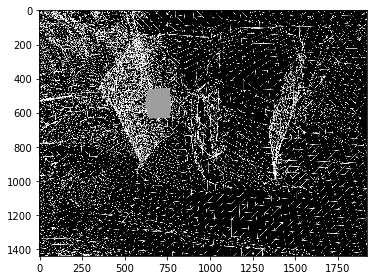

In [ ]:
color_img, depth = renderer.render(scene)
ski.io.imshow(color_img)
ski.io.show()

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


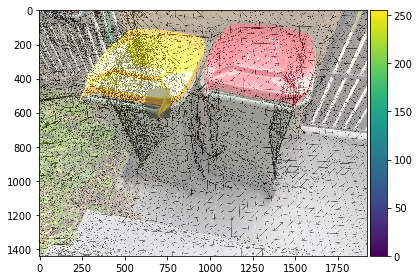

In [ ]:
alpha = 0.5
inverted = ski.util.invert(color_img)
blended =  np.floor(alpha*photo + (1-alpha)*inverted)
blended = blended.astype(int)

ski.io.imshow(blended)
ski.io.show()

(-1.8594618082046508, 0.7895047783851622, -0.8226267814636229)
(687, 535)
[(241, 101), (1002, 1060)]
[(935, 74), (1599, 1088)]


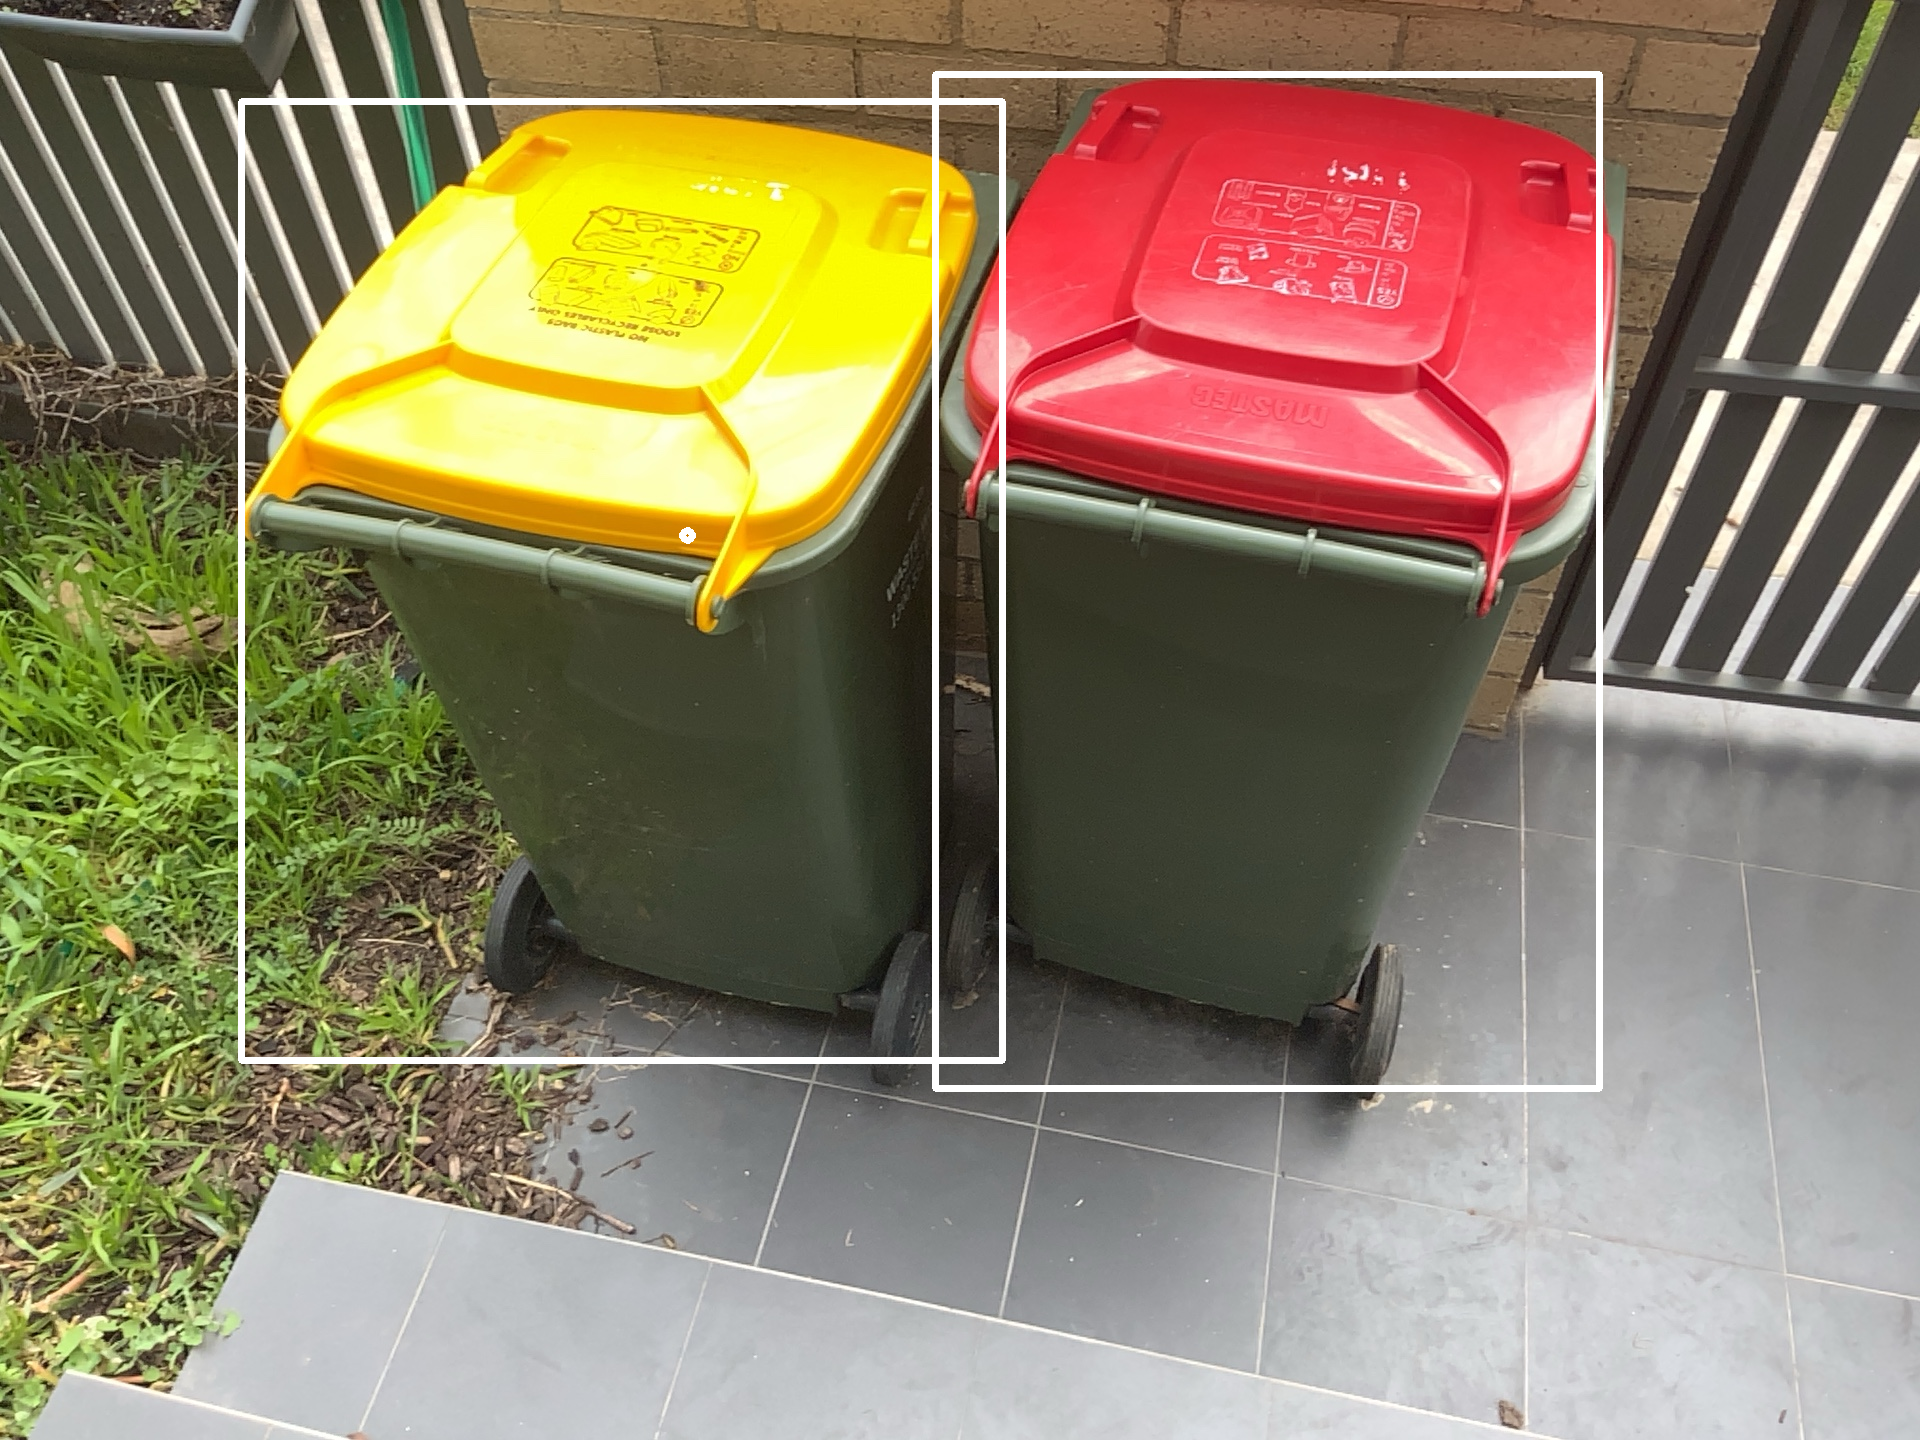

In [ ]:
from google.colab.patches import cv2_imshow

box3d = (simple_pose[0][3], simple_pose[1][3], simple_pose[2][3])
print(box3d)
box2d = project_point_mvp(box3d, mvp, img_w, img_h)
print(box2d)
bbox = cv2.imread('frame_00019.jpg')
color = (255, 255, 255)
color2 = (100, 100, 100)
thickness =5
for bb in bboxs:
  print(bb)
  bbox = cv2.rectangle(bbox, bb[0], bb[1], color, thickness) 
#cv2.circle(bbox,mid1,thickness, color)
cv2.circle(bbox,box2d,radius = 5, thickness=thickness, color=color)
cv2_imshow(bbox)
